# Analysis of U.S. Suicide Rates

Jaime Lu and Rohit Varadhan

## Introduction

The mental health of individuals is a critical, growing concern. The prevalence of mental health issues has been increasing at an alarming rate, including [suicide](https://www.nimh.nih.gov/health/statistics/suicide). Despite being one of the leading causes of death globally, the complexity of suicide rates in the United States is not analyzed as urgently as it should. Suicide rates reflect not only individual mental health struggles but also broader systemic issues spanning healthcare, social support systems, and cultural attitudes toward mental well-being.
Recognizing and understanding some of the intricate dynamics of societal well-being and the factors influencing it is our motivation for our project. This tutorial focuses on official data collected by the [government’s open data catalog](https://catalog.data.gov/dataset), reporting United States suicide rates by sex, race, age, and origin from 1980 to 2018. 

### Purpose

Today we will guide you through a simple tutorial of cleaning, analyzing, and interpreting data. Our goal is to get a better understanding of the demographic patterns and changes in suicide rate over time. This will help dissect some of the factors regarding suicide that can help pave the way for informed decision-making and proactive measures to prevent suicide. 

In [359]:
# imports
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

## Data Collection

After downloading the [data](https://www.kaggle.com/datasets/varundeepakgudhe/u-s-suicide-rates-by-sex-race-age-origin/data) and storing it in the same folder as your Jupyter file, we will read in the data.

In [360]:
# load the data
data = pd.read_csv("Death_rates_for_suicide__by_sex__race__Hispanic_origin__and_age__United_States.csv")

## Data Processing

We will using Pandas and NumPy to manipulate our dataframes. To learn more about these libraries and their functionality, check out their documentations:
[Pandas Documentation](https://pandas.pydata.org/docs/index.html)
[Numpy Documentation](https://numpy.org/doc/stable/index.html)

In [361]:
#Printing the current columns 
print(data.columns)

Index(['INDICATOR', 'UNIT', 'UNIT_NUM', 'STUB_NAME', 'STUB_NAME_NUM',
       'STUB_LABEL', 'STUB_LABEL_NUM', 'YEAR', 'YEAR_NUM', 'AGE', 'AGE_NUM',
       'ESTIMATE', 'FLAG'],
      dtype='object')


### Understanding the Data

Here is what each column represents 
**INDICATOR**: Describes the data represented in the row
**UNIT**: The measurement unit for the data
**UNIT_NUM**: A numerical code to identify the type of unit used in the UNIT column
**STUB_NAME**: A broad category descriptor for the data in the row
**STUB_NAME_NUM**: Numerical code corresponding to the STUB_NAME
**STUB_LABEL**: Provides more detailed labeling within the category from STUB_NAME
**STUB_LABEL_NUM**: A further numerical designation for STUB_LABEL
**YEAR**: The year for the data
**YEAR_NUM**: A numerical code for the YEAR
**AGE**: Specifies the age group for the data
**AGE_NUM**: Numerical code corresponding to the AGE
**ESTIMATE**: The actual statistical value or estimate of the suicide rate
**FLAG**: A column likely used to indicate any special notes or exceptions about the data in the row

However, we won't be using all of these so we should adjust our Dataframe for our purpose. 

### Cleaning the Dataframe

We are going to clean up some unneccessary columns for better visualization of what the data looks like. This is also important for what we will do later.

In [362]:
# Clean the data
data.drop(data[(data['UNIT_NUM'] == 0) | (data['UNIT_NUM'] == 1) | (data['YEAR'] < 1980)].index, inplace=True)
data.drop(columns=['INDICATOR', 'FLAG', 'UNIT', 'STUB_NAME_NUM', 'YEAR_NUM', 'UNIT_NUM'], inplace=True)

# Extract sex information from 'STUB_LABEL', we'll use this later
data['SEX'] = data['STUB_LABEL'].apply(lambda x: 'Male' if 'Male' in x else ('Female' if 'Female' in x else 'All'))

# Filter data for men and women
men_data = data[data['SEX'] == 'Male'].copy()
women_data = data[data['SEX'] == 'Female'].copy()

# Remove rows with NaN values in the 'ESTIMATE' column
men_data.dropna(subset=['ESTIMATE'], inplace=True)
women_data.dropna(subset=['ESTIMATE'], inplace=True)

data.head(19)

,STUB_NAME,STUB_LABEL,STUB_LABEL_NUM,YEAR,AGE,AGE_NUM,ESTIMATE,SEX
698,Total,All persons,0.0,1980,All ages,0.0,11.9,All
728,Total,All persons,0.0,1981,All ages,0.0,12.0,All
817,Total,All persons,0.0,1982,All ages,0.0,12.2,All
818,Total,All persons,0.0,1983,All ages,0.0,12.1,All
819,Total,All persons,0.0,1984,All ages,0.0,12.4,All
820,Total,All persons,0.0,1985,All ages,0.0,12.4,All
821,Total,All persons,0.0,1986,All ages,0.0,12.9,All
822,Total,All persons,0.0,1987,All ages,0.0,12.7,All
823,Total,All persons,0.0,1988,All ages,0.0,12.4,All
824,Total,All persons,0.0,1989,All ages,0.0,12.2,All


We can view the features of the dataframe above. 

## Data Visualization and Analysis

Now that we have our data, we can start thinking how to analyze our data. To do this, we'll need to get a better feel for the content in our dataframe and how they realte to each other. Let's first look at a graph of the U.S. Suicide Rates for All Persons from 1980 to 2018.

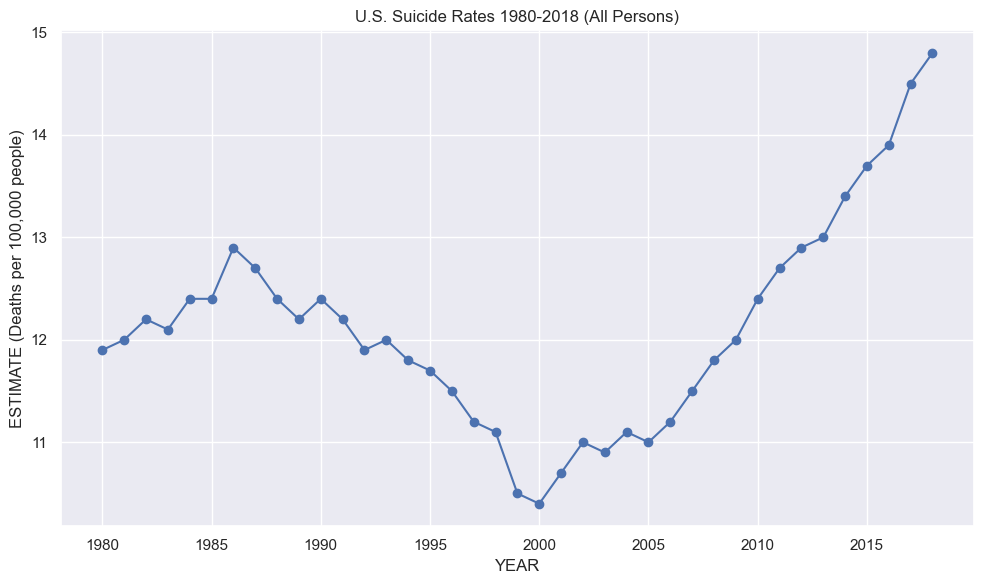

In [363]:
# Our first data visualization: Estimate vs Year for the 'All Persons' demographic category so we can get a general sense of the suicide rates
all_persons_data = data[data['STUB_LABEL'] == 'All persons'].copy()

all_persons_data.sort_values(by='YEAR', inplace=True)

plt.figure(figsize=(10,6))
plt.plot(all_persons_data['YEAR'], all_persons_data['ESTIMATE'], marker='o')
plt.xlabel('YEAR')
plt.ylabel('ESTIMATE (Deaths per 100,000 people)')
plt.title('U.S. Suicide Rates 1980-2018 (All Persons)')

plt.xticks(range(min(all_persons_data['YEAR']),max(all_persons_data['YEAR']) + 1, 5))

plt.grid(True)
plt.tight_layout()
plt.show()

Hmm, interesting! Some things to note:
- Slow increase in Suicide Rate from 1980 to 1986
- Steady decrease from 1986 to 2000
- Consistent increase from 2000 onward

However, this visualization alone does not give us much to work with. Let's now visualize suicide rates (Estimate) by age group with a box plot.

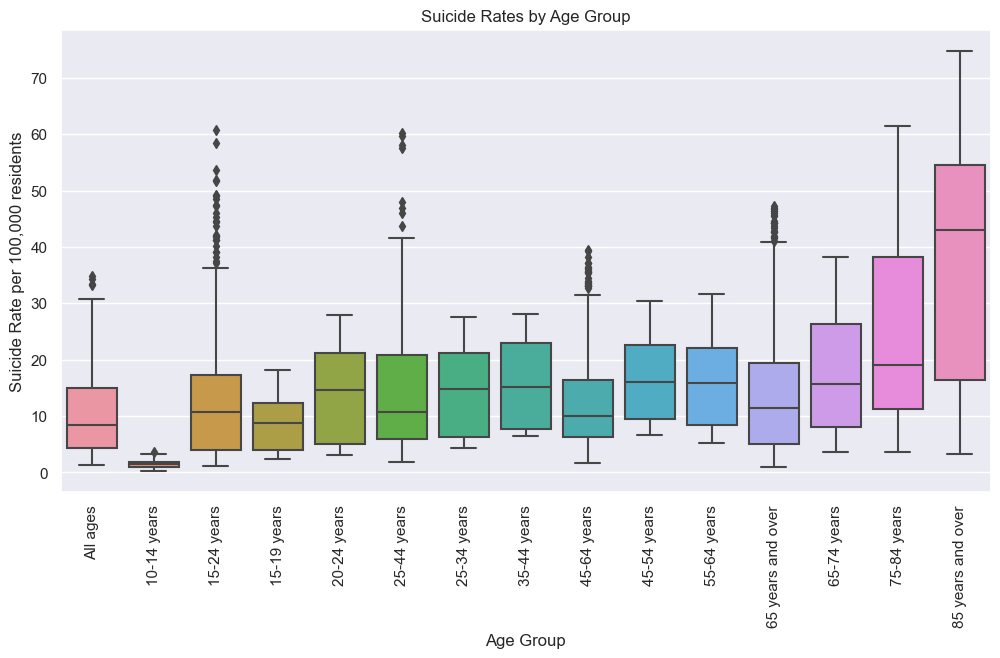

In [364]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='AGE', y='ESTIMATE')
plt.title('Suicide Rates by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Suicide Rate per 100,000 residents')
plt.xticks(rotation=90)
plt.show()

As you can see in the above box plot, it seems that across all years, suicide rates seem to increase the older the
age group is. There is also a very clear rise in rates at the final "85 and older" age group, in which the mean
suicide rate sits at over 40 per 100,000 individuals, which is more than double the suicide rate of the previous
group, "75-84 years".

Looking at age groups we can start to notice that age could be a strong factor for suicide rate.
Let's combine age and year using a heatmap to look at 2 attributes of the Suicide Rates from 1950 to 2018.

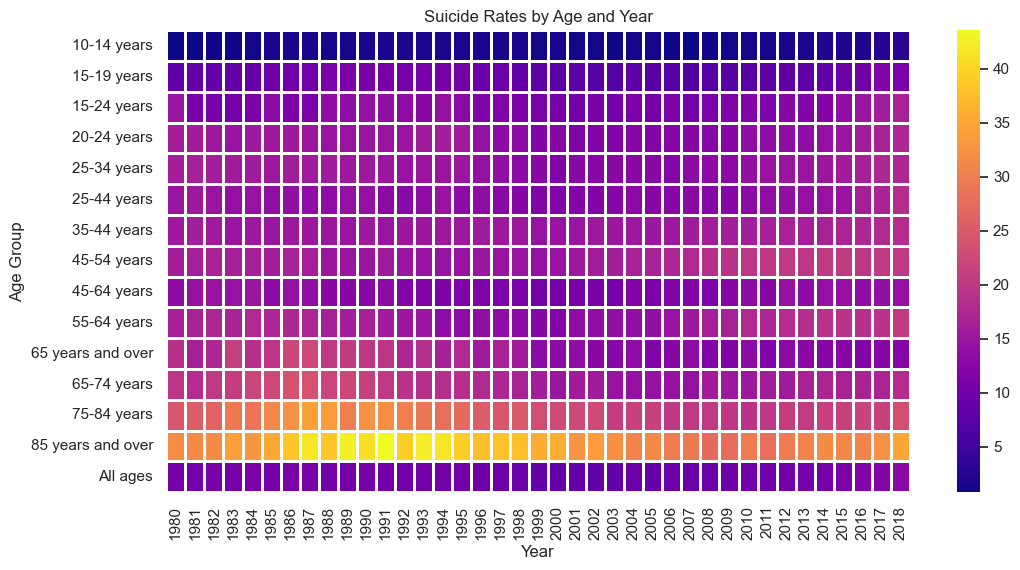

In [365]:
pivot_table = data.pivot_table(values='ESTIMATE', index='AGE', columns='YEAR', aggfunc='mean')
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap='plasma', linecolor='white', linewidths=1)
plt.title('Suicide Rates by Age and Year')
plt.xlabel('Year')
plt.ylabel('Age Group')
plt.show()

As you can see in the above heat map, it once again shows how apparently high the suicide rate is for the "85 and older" age group, glowing a bright yellow for all years. what is more important to note through this map, however, is the noticable rise in suicide rates for younger age groups since the 1990's. This rise can mainly be seen consistently across groups of "15-24 years" up to "45-54 years", which is could be evident of many factors and events throughout the years, including economic factors such as the stock market crash of 2008, as well as social factors such as the rise of social media and the internet in the early 2000's, which would mainly affect younger people. While these are all possibilities, it is impossible to know the direct cause of the increase through this data alone.

Now that we've analyzed suicide rates based on age, let's now look at the effect of dividing the data based on sex.

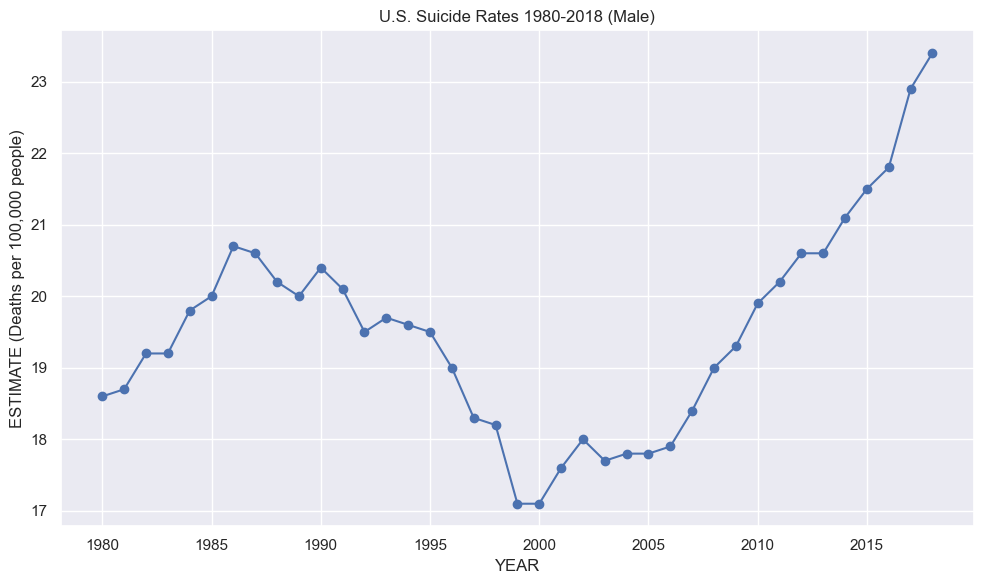

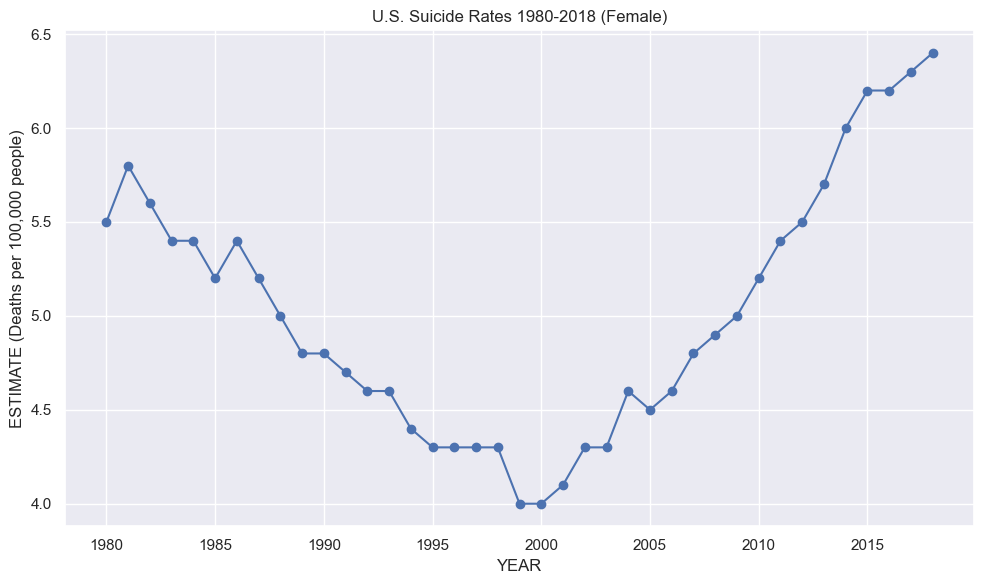

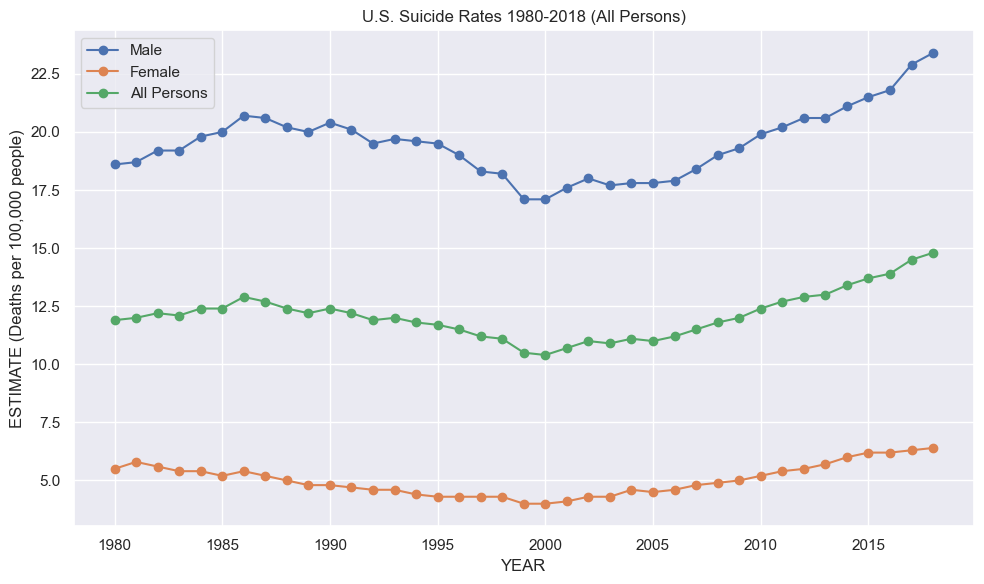

In [366]:
male_data = data[data['STUB_LABEL'] == 'Male'].copy()

male_data.sort_values(by='YEAR', inplace=True)

female_data = data[data['STUB_LABEL'] == 'Female'].copy()

female_data.sort_values(by='YEAR', inplace=True)

plt.figure(figsize=(10,6))
plt.plot(male_data['YEAR'], male_data['ESTIMATE'], marker='o')
plt.xlabel('YEAR')
plt.ylabel('ESTIMATE (Deaths per 100,000 people)')
plt.title('U.S. Suicide Rates 1980-2018 (Male)')

plt.xticks(range(min(male_data['YEAR']),max(male_data['YEAR']) + 1, 5))

plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(female_data['YEAR'], female_data['ESTIMATE'], marker='o')
plt.xlabel('YEAR')
plt.ylabel('ESTIMATE (Deaths per 100,000 people)')
plt.title('U.S. Suicide Rates 1980-2018 (Female)')

plt.xticks(range(min(female_data['YEAR']),max(female_data['YEAR']) + 1, 5))

plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(male_data['YEAR'], male_data['ESTIMATE'], marker='o', label='Male')
plt.plot(female_data['YEAR'], female_data['ESTIMATE'], marker='o', label='Female')
plt.plot(all_persons_data['YEAR'], all_persons_data['ESTIMATE'], marker='o', label='All Persons')
plt.xlabel('YEAR')
plt.ylabel('ESTIMATE (Deaths per 100,000 people)')
plt.title('U.S. Suicide Rates 1980-2018 (All Persons)')

plt.xticks(range(min(all_persons_data['YEAR']),max(all_persons_data['YEAR']) + 1, 5))

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

We can also look at this data on the same graph.

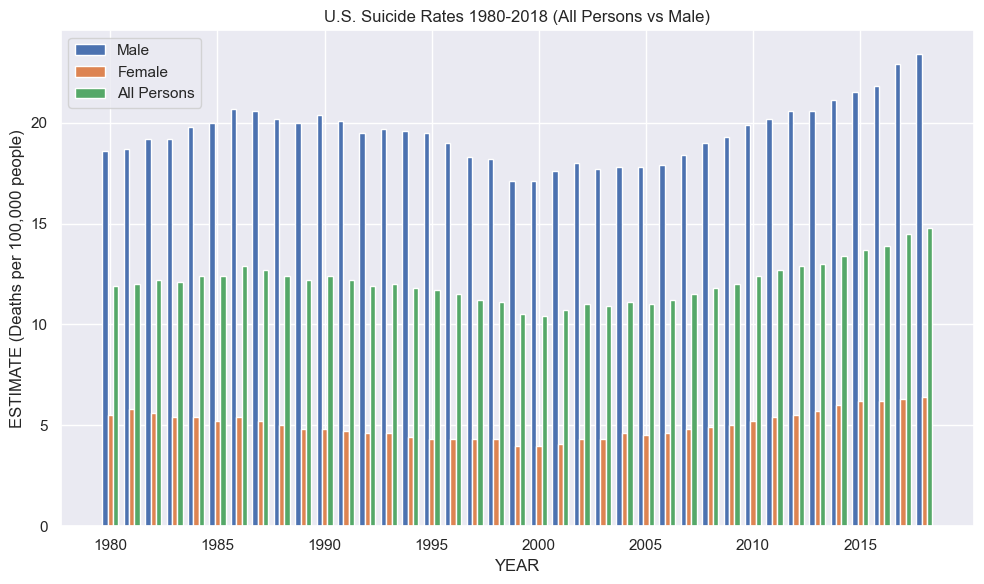

In [367]:
bar_width = .25

bar_positions_male = male_data['YEAR'].values - bar_width
bar_positions_female = female_data['YEAR'].values
bar_positions_all = all_persons_data['YEAR'].values + bar_width

plt.figure(figsize=(10,6))
plt.bar(bar_positions_male, male_data['ESTIMATE'], width=bar_width, label='Male')
plt.bar(bar_positions_female, female_data['ESTIMATE'], width=bar_width, label='Female')
plt.bar(bar_positions_all, all_persons_data['ESTIMATE'], width=bar_width, label='All Persons')
plt.xlabel('YEAR')
plt.ylabel('ESTIMATE (Deaths per 100,000 people)')
plt.title('U.S. Suicide Rates 1980-2018 (All Persons vs Male)')

plt.xticks(range(min(all_persons_data['YEAR']),max(all_persons_data['YEAR']) + 1, 5))

plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

As you can see in the above plots, there is a very clear divide in the suicide rates of men compared to women. On
one side of the coin, men have an exceedingly high suicide rate, averaging consistently around 20 people per 
100,000. On the other hand, women seem to fall fairly under the rate set by the general "all persons" group, as
their suicide rates seem to hover around 5 people per 100,000. The change in rate also seems to be more volatile 
with men as compared to women. 


One more category in which we are also going to check suicide rates is rates based on race. We will specifically be
comparing White, African American, American Indian, Asian and Pacific Islander, and Hispanic rates.

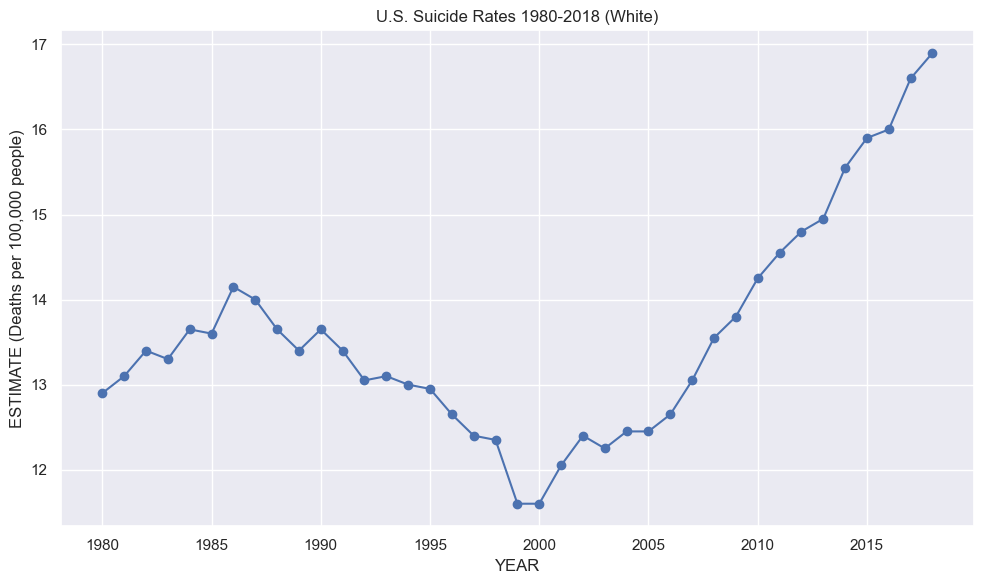

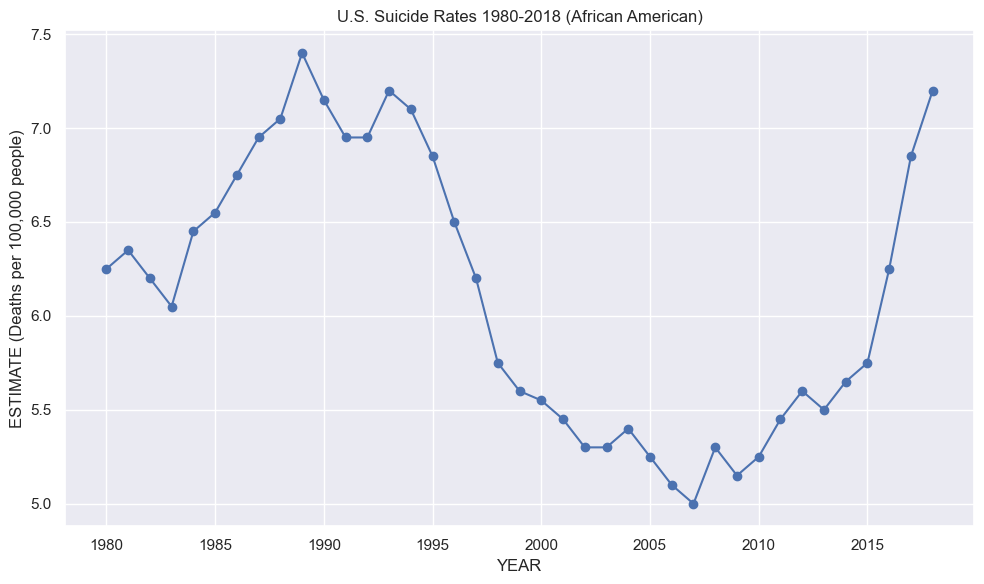

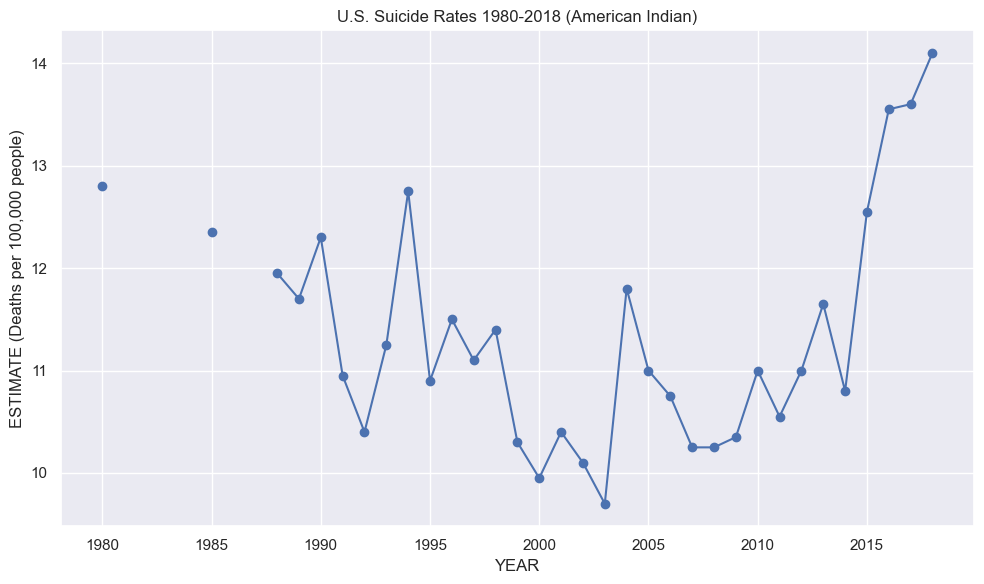

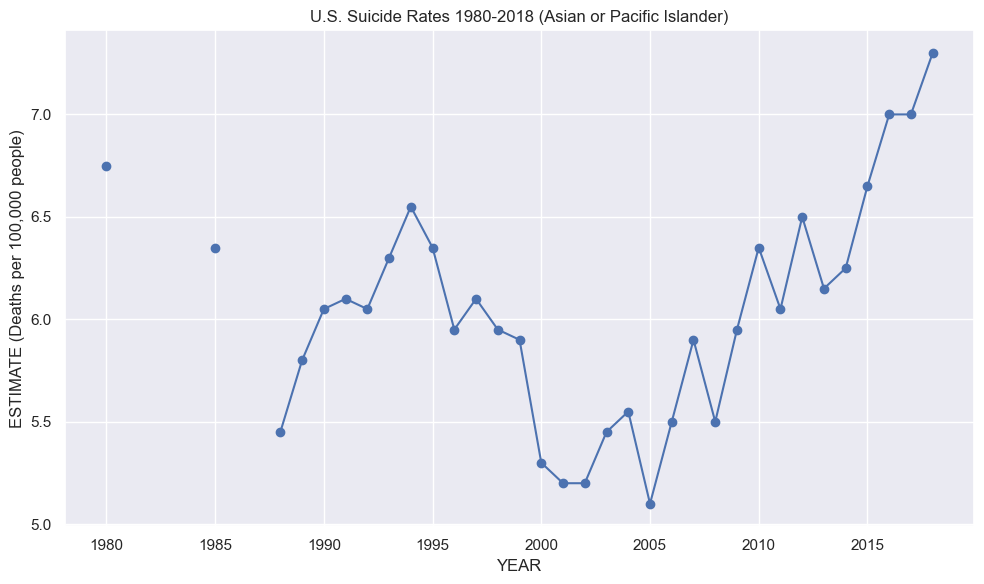

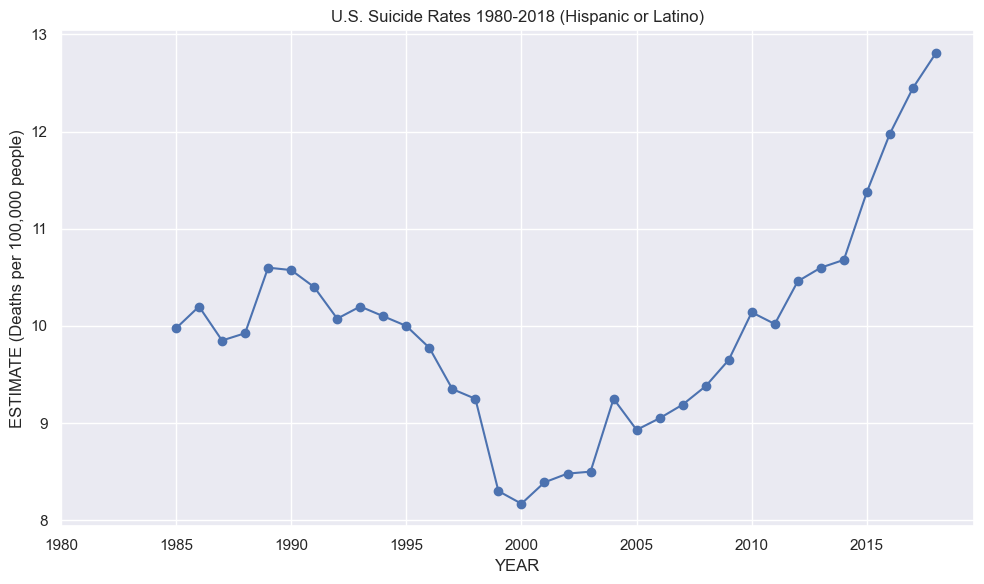

In [368]:
white_data = data[(data['STUB_LABEL'].str.contains('White')) & (data['STUB_NAME'] == 'Sex and race')].copy()

white_data_avg = white_data.groupby('YEAR')['ESTIMATE'].mean().reset_index()
white_data_avg.sort_values(by='YEAR', inplace=True)

aa_data = data[(data['STUB_LABEL'].str.contains('Black')) & (data['STUB_NAME'] == 'Sex and race')].copy()

aa_data_avg = aa_data.groupby('YEAR')['ESTIMATE'].mean().reset_index()
aa_data_avg.sort_values(by='YEAR', inplace=True)

ai_data = data[(data['STUB_LABEL'].str.contains('Indian')) & (data['STUB_NAME'] == 'Sex and race')].copy()

ai_data_avg = ai_data.groupby('YEAR')['ESTIMATE'].mean().reset_index()
ai_data_avg.sort_values(by='YEAR', inplace=True)

ap_data = data[(data['STUB_LABEL'].str.contains('Asian')) & (data['STUB_NAME'] == 'Sex and race')].copy()

ap_data_avg = ap_data.groupby('YEAR')['ESTIMATE'].mean().reset_index()
ap_data_avg.sort_values(by='YEAR', inplace=True)

hl_data = data[(data['STUB_LABEL'].str.contains('Hispanic')) & (data['STUB_NAME'] == 'Sex and race and Hispanic origin')].copy()

hl_data_avg = hl_data.groupby('YEAR')['ESTIMATE'].mean().reset_index()
hl_data_avg.sort_values(by='YEAR', inplace=True)

plt.figure(figsize=(10,6))
plt.plot(white_data_avg['YEAR'], white_data_avg['ESTIMATE'], marker='o')
plt.xlabel('YEAR')
plt.ylabel('ESTIMATE (Deaths per 100,000 people)')
plt.title('U.S. Suicide Rates 1980-2018 (White)')

plt.xticks(range(min(white_data_avg['YEAR']),max(white_data_avg['YEAR']) + 1, 5))

plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(aa_data_avg['YEAR'], aa_data_avg['ESTIMATE'], marker='o')
plt.xlabel('YEAR')
plt.ylabel('ESTIMATE (Deaths per 100,000 people)')
plt.title('U.S. Suicide Rates 1980-2018 (African American)')

plt.xticks(range(min(aa_data_avg['YEAR']),max(aa_data_avg['YEAR']) + 1, 5))

plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(ai_data_avg['YEAR'], ai_data_avg['ESTIMATE'], marker='o')
plt.xlabel('YEAR')
plt.ylabel('ESTIMATE (Deaths per 100,000 people)')
plt.title('U.S. Suicide Rates 1980-2018 (American Indian)')

plt.xticks(range(min(ai_data_avg['YEAR']),max(ai_data_avg['YEAR']) + 1, 5))

plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(ap_data_avg['YEAR'], ap_data_avg['ESTIMATE'], marker='o')
plt.xlabel('YEAR')
plt.ylabel('ESTIMATE (Deaths per 100,000 people)')
plt.title('U.S. Suicide Rates 1980-2018 (Asian or Pacific Islander)')

plt.xticks(range(min(ap_data_avg['YEAR']),max(ap_data_avg['YEAR']) + 1, 5))

plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(hl_data_avg['YEAR'], hl_data_avg['ESTIMATE'], marker='o')
plt.xlabel('YEAR')
plt.ylabel('ESTIMATE (Deaths per 100,000 people)')
plt.title('U.S. Suicide Rates 1980-2018 (Hispanic or Latino)')

plt.xticks(range(min(hl_data_avg['YEAR']),max(hl_data_avg['YEAR']) + 1, 5))

plt.grid(True)
plt.tight_layout()
plt.show()

### Filling in Missing Data

Uh-oh, it looks like we have some missing data value for the American Indian, Asian and Pacific Islanders, and 
Hispanic data sets. we'll need to use something to fill in this missing data. We know that what's missing is the 'ESTIMATE' values for the specific years. To obtain the missing values, we will use SKLearn's KNNImputer on the specified sets to find the missing data points based on the nearest neighbors. What gave us the best outputs were having the nearest neighbor's at 5, 3, and 5 respectively and using uniform weight.

In [369]:
# K's Nearest Neighbor's Function
def KNNMissing(i, dataset):
    data_missing = dataset[dataset['ESTIMATE'].isnull()].copy()
    data_complete = dataset[~dataset['ESTIMATE'].isnull()].copy()

    data_complete_feat = data_complete[['YEAR', 'ESTIMATE', 'STUB_LABEL_NUM']].values
    data_missing_feat = data_missing[['YEAR', 'ESTIMATE', 'STUB_LABEL_NUM']].values

    imputer = KNNImputer(n_neighbors=i, weights="uniform")
    imputer.fit(data_complete_feat)
    data_missing_imputed = imputer.transform(data_missing_feat)

    data_missing[['YEAR', 'ESTIMATE', 'STUB_LABEL_NUM']] = data_missing_imputed

    data_imputed = pd.concat([data_complete, data_missing])
    
    return data_imputed

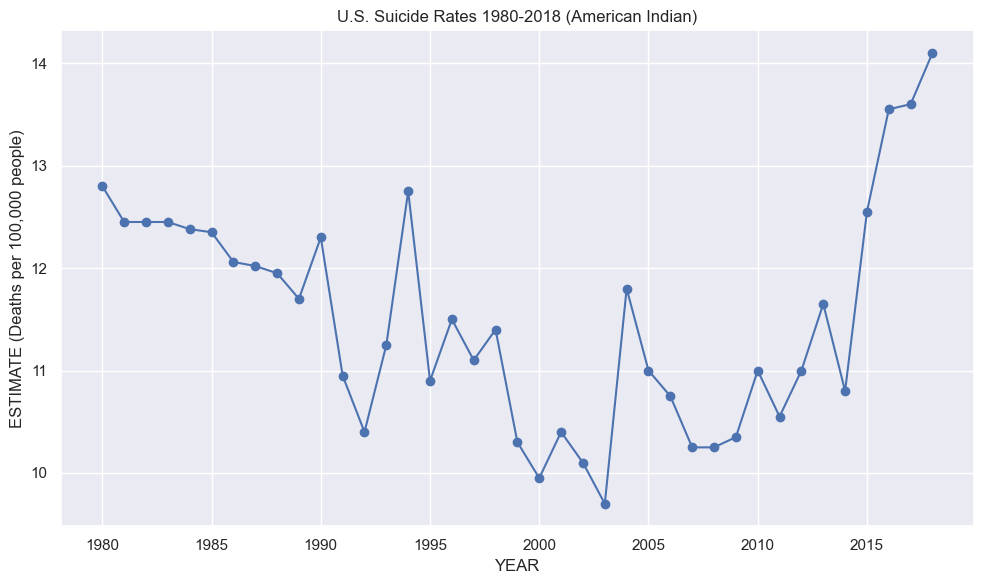

In [370]:
ai_data = data[(data['STUB_LABEL'].str.contains('Indian')) & (data['STUB_NAME'] == 'Sex and race')].copy()
ai_data = KNNMissing(5, ai_data)

ai_data_avg = ai_data.groupby('YEAR')['ESTIMATE'].mean().reset_index()
ai_data_avg.sort_values(by='YEAR', inplace=True)
ai_data_avg['YEAR'] = ai_data_avg['YEAR'].astype(int)

plt.figure(figsize=(10,6))
plt.plot(ai_data_avg['YEAR'], ai_data_avg['ESTIMATE'], marker='o')
plt.xlabel('YEAR')
plt.ylabel('ESTIMATE (Deaths per 100,000 people)')
plt.title('U.S. Suicide Rates 1980-2018 (American Indian)')

plt.xticks(range(min(ai_data_avg['YEAR']),max(ai_data_avg['YEAR']) + 1, 5))

plt.grid(True)
plt.tight_layout()
plt.show()


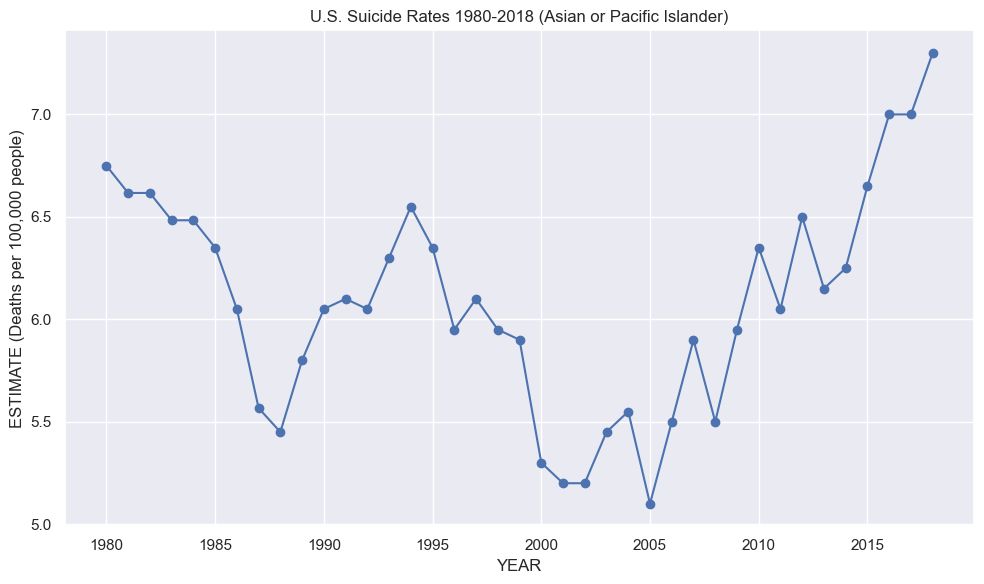

In [371]:
ap_data = data[(data['STUB_LABEL'].str.contains('Asian')) & (data['STUB_NAME'] == 'Sex and race')].copy()
ap_data = KNNMissing(3, ap_data)

ap_data_avg = ap_data.groupby('YEAR')['ESTIMATE'].mean().reset_index()
ap_data_avg.sort_values(by='YEAR', inplace=True)
ap_data_avg['YEAR'] = ap_data_avg['YEAR'].astype(int)

plt.figure(figsize=(10,6))
plt.plot(ap_data_avg['YEAR'], ap_data_avg['ESTIMATE'], marker='o')
plt.xlabel('YEAR')
plt.ylabel('ESTIMATE (Deaths per 100,000 people)')
plt.title('U.S. Suicide Rates 1980-2018 (Asian or Pacific Islander)')

plt.xticks(range(min(ap_data_avg['YEAR']),max(ap_data_avg['YEAR']) + 1, 5))

plt.grid(True)
plt.tight_layout()
plt.show()

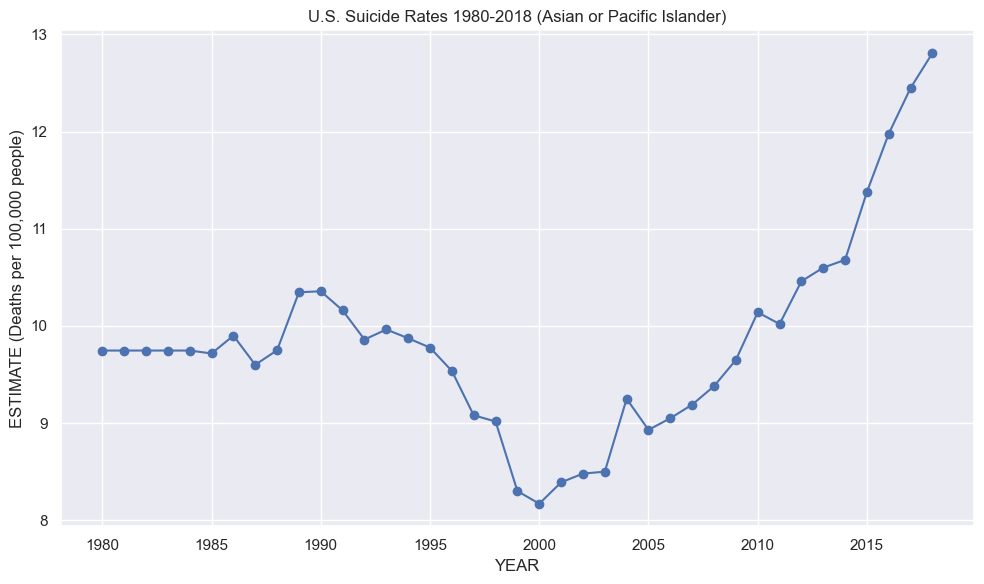

In [372]:
hl_data = data[(data['STUB_LABEL'].str.contains('Hispanic')) & (data['STUB_NAME'] == 'Sex and race and Hispanic origin')].copy()
hl_data = KNNMissing(5, hl_data)

hl_data_avg = hl_data.groupby('YEAR')['ESTIMATE'].mean().reset_index()
hl_data_avg.sort_values(by='YEAR', inplace=True)
hl_data_avg['YEAR'] = hl_data_avg['YEAR'].astype(int)

plt.figure(figsize=(10,6))
plt.plot(hl_data_avg['YEAR'], hl_data_avg['ESTIMATE'], marker='o')
plt.xlabel('YEAR')
plt.ylabel('ESTIMATE (Deaths per 100,000 people)')
plt.title('U.S. Suicide Rates 1980-2018 (Asian or Pacific Islander)')

plt.xticks(range(min(hl_data_avg['YEAR']),max(hl_data_avg['YEAR']) + 1, 5))

plt.grid(True)
plt.tight_layout()
plt.show()

Now, we will showcase the mean suicide rates for different races

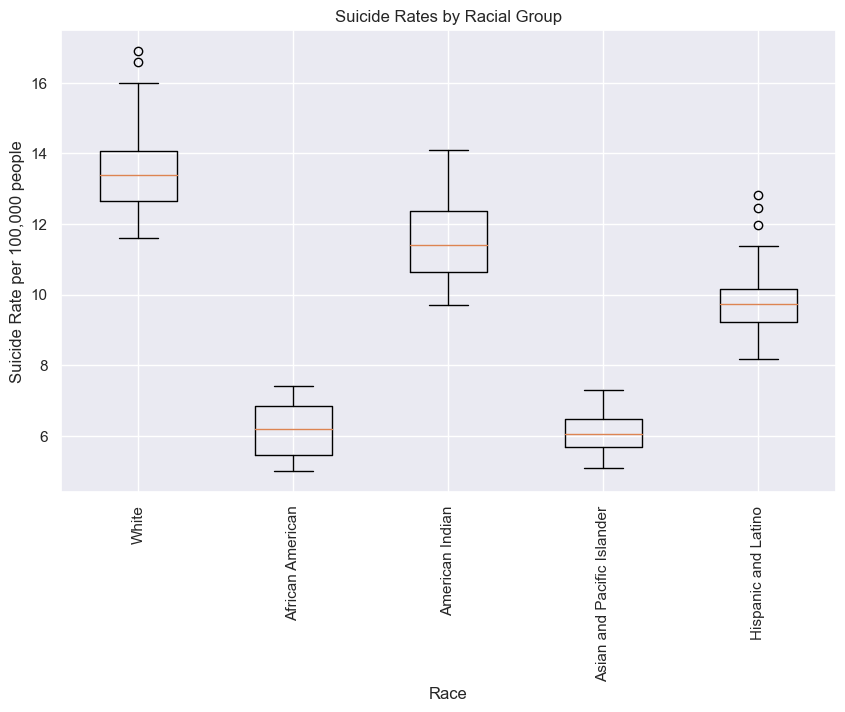

In [373]:
race_data = [white_data_avg, aa_data_avg, ai_data_avg, ap_data_avg, hl_data_avg]

suicide_rates = [curr['ESTIMATE'].values for curr in race_data]

labels = ['White', 'African American', 'American Indian', 'Asian and Pacific Islander', 'Hispanic and Latino']

plt.figure(figsize=(10, 6))
plt.boxplot(suicide_rates, labels=labels)
plt.title('Suicide Rates by Racial Group')
plt.xlabel('Race')
plt.ylabel('Suicide Rate per 100,000 people')
plt.xticks(rotation=90)
plt.show()

### Analysis
With all the completed data, we can now observe and compare the trends and values of the graphs.

One noticable trend in the data is an apparent drop off in rates going from the start of the 1990's to 2000,
followed by a steep increase from there on. The most erratic of the groups in terms of trends is the American Indian group, which overall still follows the general trend displayed in the other groups, but has noticable jumps throughout the years, specifically in 2005.

As for values, Asian American and Pacific Islanders alongside African Americans had noticably lower suicide rates
than the other groups, perhaps due to cultural differences between the groups.

After analyzing the suicide rates over time based on various factors, including, sex, age, and race, one main trend
that was seen in all graphs was the slight drop off in rates from 1995 to 2000, followed by a steep increase up
until 2018.

Our hypothesis for this trend is that the rate change among every group is either related to political factors,
specifically noticing the change in US war involvement during that time period, or social factors, considering the rise of social media and it's effects of mental health issues arising from it.

## Model: Predictive Testing & Machine Learning

For the Model phase of the Data Lifecycle, we are going to use linear regression in order to obtain a predictive model of our data. This will allow us to predict values for data outside of our time frame of 2018. 

First we are going to prepare the data by selecting our feature adn target variable. For now we will use just the year and age group to make our predictive model.

In [374]:
def prepare_data(data):
    # Select features and target variable
    features = ['YEAR', 'AGE_NUM']
    target = 'ESTIMATE'
    
    # Create the feature matrix (X) and target vector (y)
    X = data[features]
    y = data[target]
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test


'''Now we want to train the model so it can learn and recognize any patterns to use for the predictive model.'''
def train_model(X_train, y_train):
    # Initialize the linear regression model
    model = LinearRegression()
    
    # Train the model
    model.fit(X_train, y_train)
    
    return model

'''We want to Evaluate the model by testing it. We will use the Mean Squared Error '''
def evaluate_model(model, X_test, y_test):
    # Make predictions on the testing set
    y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return mse, r2

'''Now that we have trained and evaluated our model, we are ready to make predictions and plot our prediction.'''
def make_predictions(model, year, age_groups):
    new_data = pd.DataFrame({
        'YEAR': [year] * len(age_groups),
        'AGE_NUM': age_groups
    })
    predictions = model.predict(new_data)
    new_data['PREDICTED_ESTIMATE'] = predictions
    
    return new_data

Men - Mean Squared Error: 127.53009056438331, R^2 Score: 0.19713496104716166
Women - Mean Squared Error: 8.801179175962178, R^2 Score: 0.01672715993299445
Predictions for Men in 2020:
    YEAR  PREDICTED_ESTIMATE                AGE
0   2020           11.106140           All ages
1   2020           14.003006        10-14 years
3   2020           17.189558        15-19 years
4   2020           17.479245        20-24 years
6   2020           20.086424        25-34 years
7   2020           20.376111        35-44 years
9   2020           22.983290        45-54 years
10  2020           23.272977        55-64 years
12  2020           25.880156        65-74 years
13  2020           26.169843        75-84 years
14  2020           28.487335  85 years and over
Predictions for Women in 2020:
    YEAR  PREDICTED_ESTIMATE                AGE
0   2020            4.464153           All ages
1   2020            4.745901        10-14 years
3   2020            5.055823        15-19 years
4   2020         

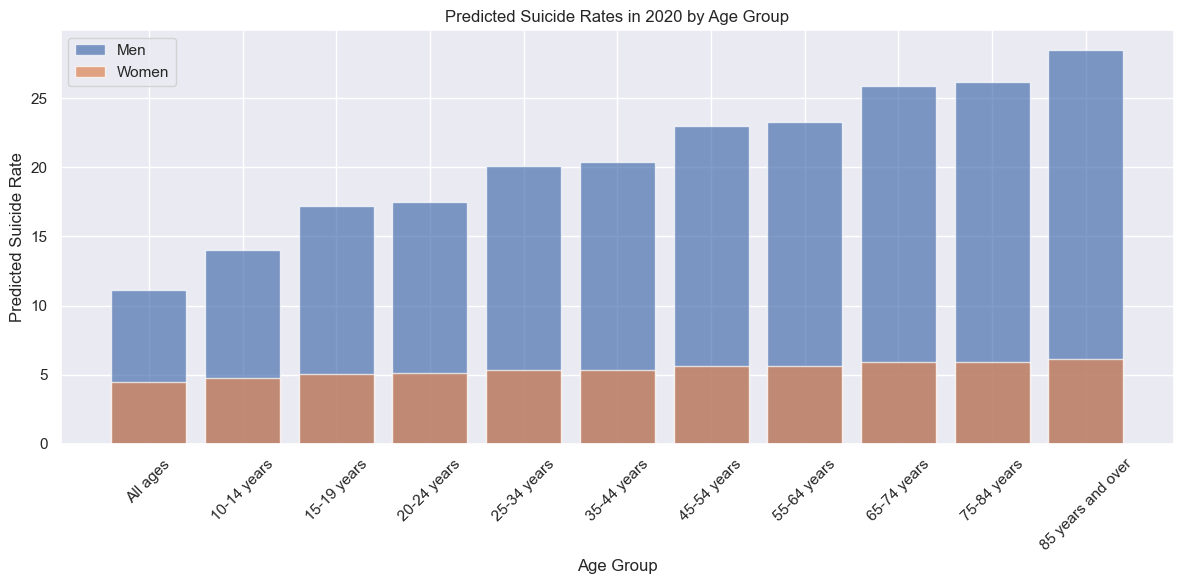

In [375]:
# Create a dictionary to map AGE_NUM to AGE
age_mapping = data[['AGE', 'AGE_NUM']].drop_duplicates().set_index('AGE_NUM').to_dict()['AGE']

# Prepare data for men and women
X_train_men, X_test_men, y_train_men, y_test_men = prepare_data(men_data)
X_train_women, X_test_women, y_train_women, y_test_women = prepare_data(women_data)

# Train models for men and women
model_men = train_model(X_train_men, y_train_men)
model_women = train_model(X_train_women, y_train_women)

# Evaluate models
mse_men, r2_men = evaluate_model(model_men, X_test_men, y_test_men)
mse_women, r2_women = evaluate_model(model_women, X_test_women, y_test_women)

print(f"Men - Mean Squared Error: {mse_men}, R^2 Score: {r2_men}")
print(f"Women - Mean Squared Error: {mse_women}, R^2 Score: {r2_women}")

# Make predictions for 2020 for all age groups
age_groups = men_data['AGE_NUM'].unique()
predictions_men_2020 = make_predictions(model_men, 2020, age_groups)
predictions_women_2020 = make_predictions(model_women, 2020, age_groups)

# Drop rows where 'AGE_NUM' is equal to 5.0
predictions_men_2020 = predictions_men_2020[(predictions_men_2020['AGE_NUM'] != 2.0) & (predictions_men_2020['AGE_NUM'] != 3.0) & (predictions_men_2020['AGE_NUM'] != 4.0) & (predictions_men_2020['AGE_NUM'] != 5.0)]
predictions_women_2020 = predictions_women_2020[(predictions_women_2020['AGE_NUM'] != 2.0) & (predictions_women_2020['AGE_NUM'] != 3.0) & (predictions_women_2020['AGE_NUM'] != 4.0) & (predictions_women_2020['AGE_NUM'] != 5.0)]


# Replace 'AGE_NUM' with 'AGE' labels in predictions_men_2020 and predictions_women_2020
predictions_men_2020['AGE'] = predictions_men_2020['AGE_NUM'].map(age_mapping)
predictions_women_2020['AGE'] = predictions_women_2020['AGE_NUM'].map(age_mapping)

# Drop the 'AGE_NUM' column from predictions dataframes
predictions_men_2020.drop(columns=['AGE_NUM'], inplace=True)
predictions_women_2020.drop(columns=['AGE_NUM'], inplace=True)

print("Predictions for Men in 2020:")
print(predictions_men_2020)

print("Predictions for Women in 2020:")
print(predictions_women_2020)

'''Plotting the Predictive Graphs'''
# Plot the results with age group labels
plt.figure(figsize=(12, 6))
plt.bar(predictions_men_2020['AGE'], predictions_men_2020['PREDICTED_ESTIMATE'], label='Men', alpha=.7)
plt.bar(predictions_women_2020['AGE'], predictions_women_2020['PREDICTED_ESTIMATE'], label='Women', alpha=.7)

plt.xticks(rotation=45)
plt.xlabel('Age Group')
plt.ylabel('Predicted Suicide Rate')
plt.title('Predicted Suicide Rates in 2020 by Age Group')
plt.legend()
plt.tight_layout()
plt.show()

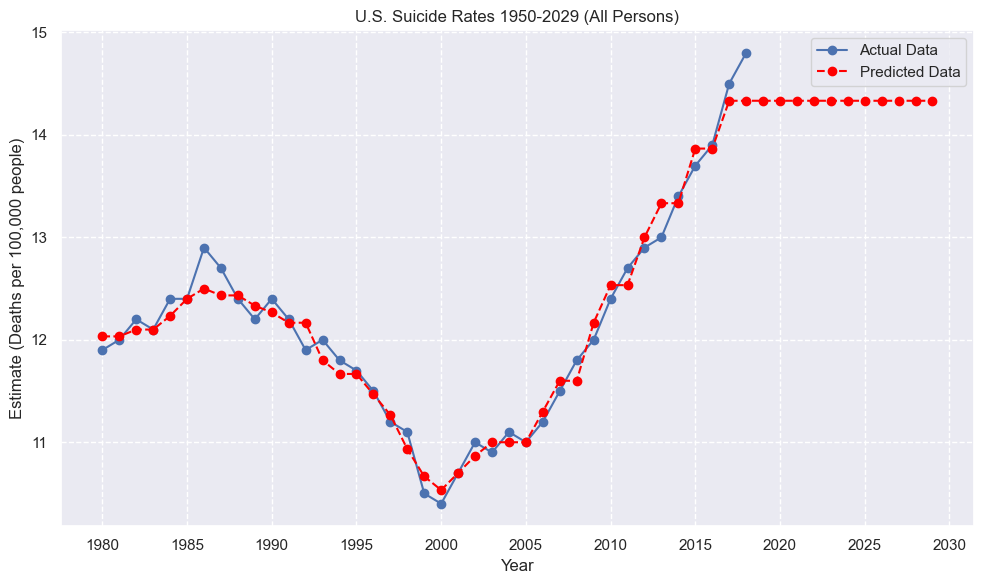

In [376]:
from sklearn.neighbors import KNeighborsRegressor
# Remove rows with NaN values in the 'ESTIMATE' column
all_persons_data.dropna(subset=['ESTIMATE'], inplace=True)

# Prepare data for linear regression
X = all_persons_data[['YEAR']].values
y = all_persons_data['ESTIMATE'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the linear regression model
model = KNeighborsRegressor(n_neighbors=3)
model.fit(X_train, y_train)

# Make predictions for the years 2019 to 2029
future_years = np.arange(1980, 2030).reshape(-1, 1)
predicted_estimates = model.predict(future_years)

# Visualize the predictions
plt.figure(figsize=(10, 6))
plt.plot(all_persons_data['YEAR'], all_persons_data['ESTIMATE'], marker='o', label='Actual Data')
plt.plot(future_years, predicted_estimates, marker='o', linestyle='--', color='red', label='Predicted Data')
plt.xlabel('Year')
plt.ylabel('Estimate (Deaths per 100,000 people)')
plt.title('U.S. Suicide Rates 1950-2029 (All Persons)')
plt.xticks(range(min(all_persons_data['YEAR']), max(future_years.ravel()) + 2, 5))  # Adjust xticks for future years
plt.grid(True, linestyle='--')  # Add grid with dashed lines
plt.legend()
plt.tight_layout()
plt.show()

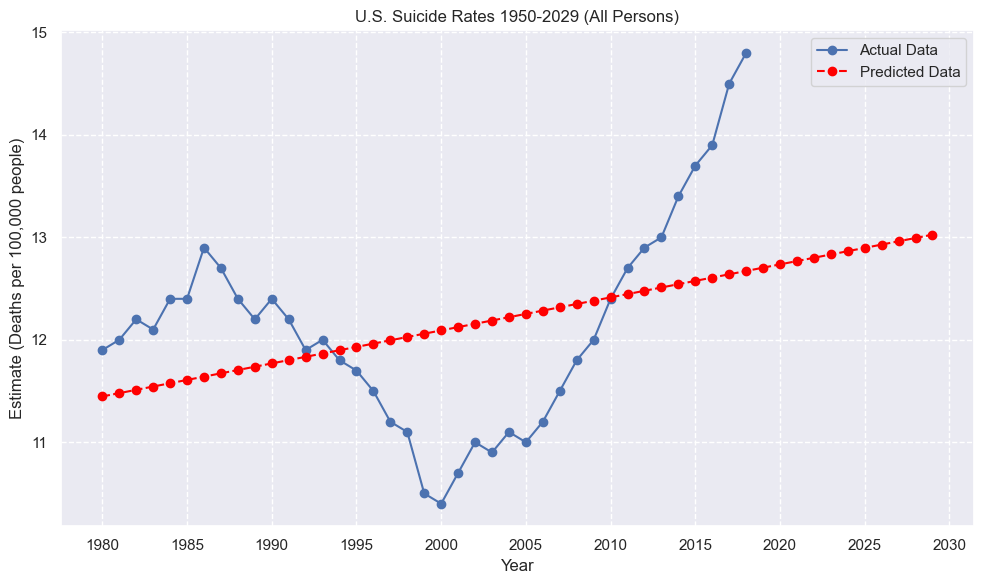

In [377]:
# Remove rows with NaN values in the 'ESTIMATE' column
all_persons_data.dropna(subset=['ESTIMATE'], inplace=True)

# Prepare data for linear regression
X = all_persons_data[['YEAR']].values
y = all_persons_data['ESTIMATE'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions for the years 2019 to 2029
future_years = np.arange(1980, 2030).reshape(-1, 1)
predicted_estimates = model.predict(future_years)

# Visualize the predictions
plt.figure(figsize=(10, 6))
plt.plot(all_persons_data['YEAR'], all_persons_data['ESTIMATE'], marker='o', label='Actual Data')
plt.plot(future_years, predicted_estimates, marker='o', linestyle='--', color='red', label='Predicted Data')
plt.xlabel('Year')
plt.ylabel('Estimate (Deaths per 100,000 people)')
plt.title('U.S. Suicide Rates 1950-2029 (All Persons)')
plt.xticks(range(min(all_persons_data['YEAR']), max(future_years.ravel()) + 2, 5))  # Adjust xticks for future years
plt.grid(True, linestyle='--')  # Add grid with dashed lines
plt.legend()
plt.tight_layout()
plt.show()

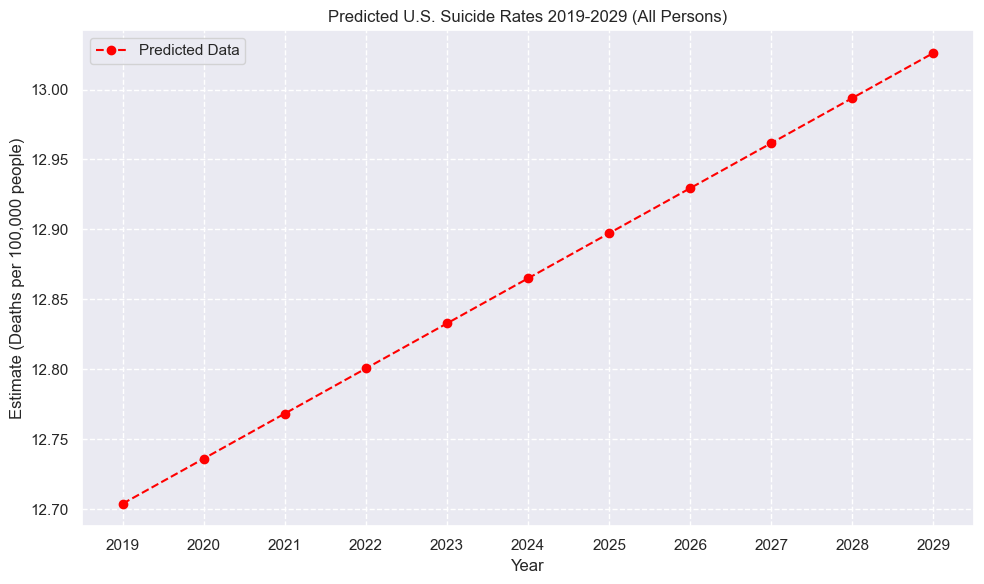

In [378]:
# Visualize the predicted data only
plt.figure(figsize=(10, 6))
plt.plot(future_years[future_years >= 2019], predicted_estimates[future_years.ravel() >= 2019], marker='o', linestyle='--', color='red', label='Predicted Data')
plt.xlabel('Year')
plt.ylabel('Estimate (Deaths per 100,000 people)')
plt.title('Predicted U.S. Suicide Rates 2019-2029 (All Persons)')
plt.xticks(range(min(future_years[future_years >= 2019].ravel()), max(future_years.ravel()) + 1, 1))  # Adjust xticks for future years
plt.grid(True, linestyle='--')  # Add grid with dashed lines
plt.legend()
plt.tight_layout()
plt.show()

## Insight & Conclusion

Yay! We have completed our data analysis for this study. Here are our conclusions:

### Predictive Modeling Statistical Conclusions

1. The 2020 predictions run on the two sex groups over age groups demonstrates the rise in rates not only as you go up in age, but also the greater intensity of the rise in rates as you go up in age groups for men than for women, for which the difference in rates is negligable
2. Running a linear regression model on the suicide rates over time for all demographics showcases the predicted rates for 2019-2030. The predictive model is not as accurate as we would like, however, due to the lack of weightage that linear regression has on different years. We tried originally to use a KNN clustering algorithm to give more accurate preditions, but unfortunately couldn't get it to work properly.
3. 

### Real World Conclusions

1.
2.
3.


We hope that after this tutorial you have a better understanding on Data Science including how to collect and process data, visualize, analyze, and train machines to make predictions.Though machines may or may not make better predictions than humans, they are a great asset to help. With larger datasets and more learning algorithms, we can make the predictions more accurate. Using Data Science, we can better learn and predict vital information and rates like Suicide Rates for different demographics so we can better understand the factors that cause suicide. 